# Wasserstein GAN in Pytorch

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, utils
%matplotlib inline

First, we, set up batch size, image size, and size of noise vector:

In [2]:
bs,sz,nz = 512,64,100
PATH_G = 'model_g_cifar'
PATH_D = 'model_d_cifar'

In [3]:
PATH = '/home/m20163692/data/cifar10'
data = datasets.CIFAR10(root=PATH, download=True,
   transform=transforms.Compose([
       transforms.Scale(sz),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)

Files already downloaded and verified


Even parallel processing is handling automatically by torch-vision.

In [4]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

98

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [5]:
def show(img, fs=(8,8)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    plt.show()

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [6]:
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import importlib
import dcgan_3conv; importlib.reload(dcgan_3conv)
from dcgan_3conv import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [7]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
netG = DCGAN_G(sz, nz, 3, 64, 2, 1).cuda()
netG.apply(weights_init);

In [9]:
netD = DCGAN_D(sz, 3, 64, 2, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [10]:
from torch import FloatTensor as FT

def Var(*params):
    return Variable(FT(*params).cuda())

def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [11]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [12]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [13]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [14]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [31]:
def train(niter, first=True):
    gen_iterations = 0
    save_flag = 1
    for epoch in range(niter):
        t0 = time()
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)
            # d_iters = 5

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                print(f'{i:04}/{gen_iterations:04}', end='\r')
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
#             if save_flag == -1:
#                 p_g = PATH_G + '_temp.pkl'
#                 p_d = PATH_D + '_temp.pkl'
#             else:
#                 p_g = PATH_G + '.pkl'
#                 p_d = PATH_D + '.pkl'
            
#             torch.save(netG.state_dict(), p_g)
#             torch.save(netD.state_dict(), p_d)
#             save_flag *= -1
            
        print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f (%.2fs)' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], time() - t0))

In [81]:
%%time
# train(6, True) # First run
train(5, False)

[0/5][1/98] Loss_D: -1.093778 Loss_G: 0.540979 Loss_D_real: -0.494488 Loss_D_fake 0.599289 (138.83s)
[1/5][21/98] Loss_D: -0.710820 Loss_G: 0.530383 Loss_D_real: -0.475604 Loss_D_fake 0.235216 (170.20s)
[2/5][41/98] Loss_D: -0.781498 Loss_G: 0.522397 Loss_D_real: -0.469759 Loss_D_fake 0.311738 (171.53s)
[3/5][61/98] Loss_D: -0.707568 Loss_G: 0.487898 Loss_D_real: -0.457363 Loss_D_fake 0.250205 (171.61s)
[4/5][81/98] Loss_D: -0.664085 Loss_G: 0.575219 Loss_D_real: -0.527904 Loss_D_fake 0.136181 (170.91s)
CPU times: user 9min 1s, sys: 4min 51s, total: 13min 53s
Wall time: 13min 43s


## View

In [96]:
torch.save(netG.state_dict(), 'temp_g.pkl')
torch.save(netD.state_dict(), 'temp_d.pkl')
# netG.load_state_dict(torch.load('temp_g.pkl'))
# netD.load_state_dict(torch.load('temp_d.pkl'))

In [83]:
fixed_noise = create_noise(bs)
fake = netG(fixed_noise[:64]).data.cpu()

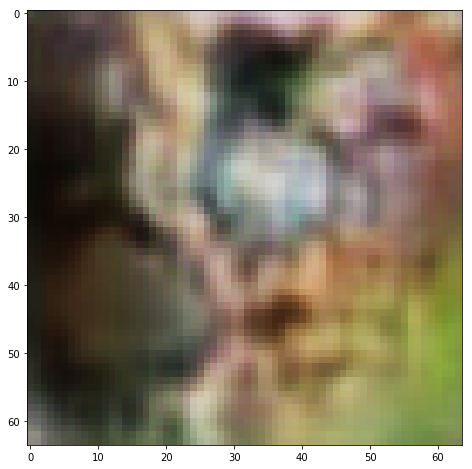

In [94]:
show(random.choice(fake))

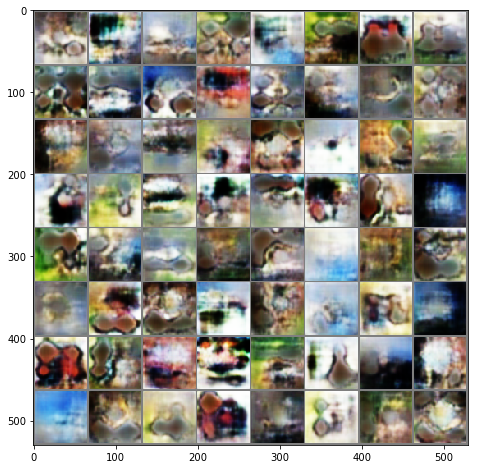

In [95]:
show(utils.make_grid(fake))

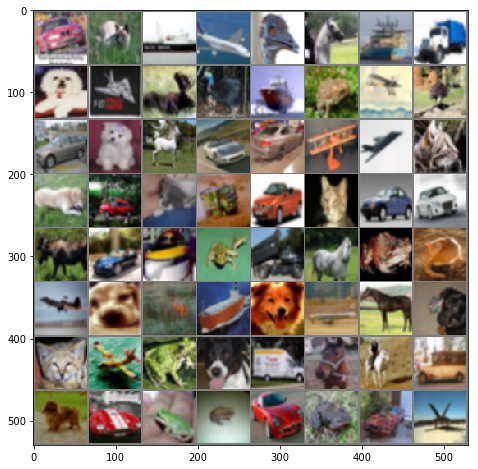

In [55]:
show(utils.make_grid(iter(dataloader).next()[0][:64]))